## AI28 - Projet - Prédiction du niveau de revenus.

In [1]:
# pip install ucimlrepo

In [2]:
# OS
import sys


# WARNINGS
import warnings

from sklearn.ensemble import AdaBoostClassifier

warnings.filterwarnings('ignore')
warnings.filterwarnings('error', category=DeprecationWarning)

# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew

# MATPLOTLIB
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight') 

params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)


# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN 
import seaborn as sns
# sns.set_context("poster")
# sns.set_style("ticks")

# SCHIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Standardisation des variables numériques
from sklearn.preprocessing import MinMaxScaler # Normalisation MinMax
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer 


# SCHIKIT-LEARN: MODELES
from sklearn import linear_model # Classe Modèle linéaire 
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso 
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier


# SCHIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visualiser les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # Tester plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage: visualisation des scores du train et du validation sets en fonction des quantités des données
 
## EVALUATION

from sklearn.metrics import r2_score, accuracy_score  # Coefficient R2
from sklearn.metrics import mean_absolute_error #  MAE
from sklearn.metrics import mean_squared_error  # RMSE
from sklearn.metrics import median_absolute_error # Erreur de la médiane absolue

# SCHIKIT-LEARN: PIPELINE AND TRANSFORMATEUR
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

# SOURCE DATA
from ucimlrepo import fetch_ucirepo 

In [3]:
# Utilisation des commandes fournies par UCI

# Télécharger le jeu de données 
data_adult = fetch_ucirepo(id=2) 

In [4]:
# data (as pandas dataframes) 
x = data_adult.data.features # variables explicatives
y = data_adult.data.targets # variables cibles

In [5]:
# metadata 
print(data_adult.metadata) 

{'uci_id': 2, 'name': 'Adult', 'repository_url': 'https://archive.ics.uci.edu/dataset/2/adult', 'data_url': 'https://archive.ics.uci.edu/static/public/2/data.csv', 'abstract': 'Predict whether annual income of an individual exceeds $50K/yr based on census data. Also known as "Census Income" dataset. ', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 48842, 'num_features': 14, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Income', 'Education Level', 'Other', 'Race', 'Sex'], 'target_col': ['income'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1996, 'last_updated': 'Tue Sep 24 2024', 'dataset_doi': '10.24432/C5XW20', 'creators': ['Barry Becker', 'Ronny Kohavi'], 'intro_paper': None, 'additional_info': {'summary': "Extraction was done by Barry Becker from the 1994 Census database.  A set of reasonably clean records was extracted using the fol

In [6]:
# variable information 
print(data_adult.variables) 

              name     role         type      demographic  \
0              age  Feature      Integer              Age   
1        workclass  Feature  Categorical           Income   
2           fnlwgt  Feature      Integer             None   
3        education  Feature  Categorical  Education Level   
4    education-num  Feature      Integer  Education Level   
5   marital-status  Feature  Categorical            Other   
6       occupation  Feature  Categorical            Other   
7     relationship  Feature  Categorical            Other   
8             race  Feature  Categorical             Race   
9              sex  Feature       Binary              Sex   
10    capital-gain  Feature      Integer             None   
11    capital-loss  Feature      Integer             None   
12  hours-per-week  Feature      Integer             None   
13  native-country  Feature  Categorical            Other   
14          income   Target       Binary           Income   

                       

## Analyse exploratoire des données

Pour réaliser l'AED, nous utilisons les données des fichiers téléchargés depuis le site web.

In [7]:
df_adult = pd.read_csv("./Data/adult.data", header=None)

In [8]:
isinstance(df_adult, pd.DataFrame)

True

Le fichier ne contient pas les noms des colonnes. Nous les ajoutons dans le dataframe adult.

In [9]:
adult_columns = data_adult.variables['name']

df_adult.columns = adult_columns

df_adult.head()

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [10]:
df_adult.shape

(32561, 15)

In [11]:
df_adult.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
       'income'],
      dtype='object', name='name')

In [12]:
df_adult.describe()

name,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [13]:
df_adult.isna().sum()

name
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [14]:
df_adult[df_adult.duplicated()]

name,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
4881,25,Private,308144,Bachelors,13,Never-married,Craft-repair,Not-in-family,White,Male,0,0,40,Mexico,<=50K
5104,90,Private,52386,Some-college,10,Never-married,Other-service,Not-in-family,Asian-Pac-Islander,Male,0,0,35,United-States,<=50K
9171,21,Private,250051,Some-college,10,Never-married,Prof-specialty,Own-child,White,Female,0,0,10,United-States,<=50K
11631,20,Private,107658,Some-college,10,Never-married,Tech-support,Not-in-family,White,Female,0,0,10,United-States,<=50K
13084,25,Private,195994,1st-4th,2,Never-married,Priv-house-serv,Not-in-family,White,Female,0,0,40,Guatemala,<=50K
15059,21,Private,243368,Preschool,1,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,50,Mexico,<=50K
17040,46,Private,173243,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,<=50K
18555,30,Private,144593,HS-grad,9,Never-married,Other-service,Not-in-family,Black,Male,0,0,40,?,<=50K
18698,19,Private,97261,HS-grad,9,Never-married,Farming-fishing,Not-in-family,White,Male,0,0,40,United-States,<=50K
21318,19,Private,138153,Some-college,10,Never-married,Adm-clerical,Own-child,White,Female,0,0,10,United-States,<=50K


In [15]:
df_adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


Problème : La description des données indique qu'elles contiennent des valeurs inconnues. Ces valeurs ne sont pas en NaN ou null. Nous pouvons déjà remarquer la présence de '?' en leur lieu et place.

## Traitement des données

<Axes: xlabel='name'>

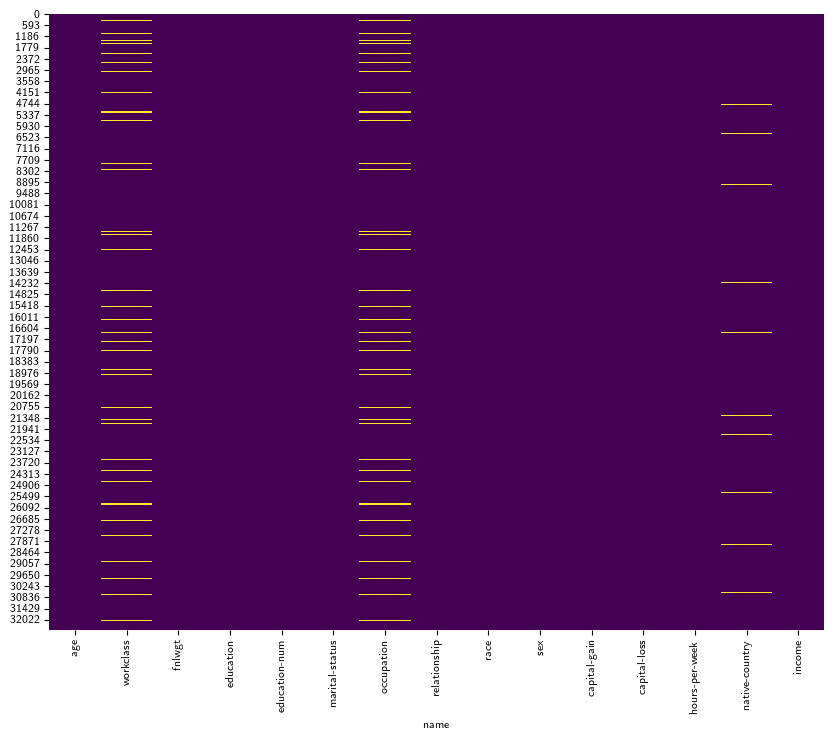

In [16]:
df_adult = df_adult.replace('\?', np.nan, regex=True)
sns.heatmap(df_adult.isna(), cbar=False, cmap='viridis')

In [17]:
# Pour l'instant, on supprime les données manquantes.
# Si ca avait été des valeurs numériques on aurait pu faire une moyenne mais il est plus compliqué de faire une moyenne sur des variables catégorielles.
n_lines = df_adult.shape[0]
df_adult = df_adult.dropna()
print(f"Nombre de lignes initial : {n_lines}")
print(f"Nombre de lignes restantes : {df_adult.shape[0]}")
rem_lines = n_lines - df_adult.shape[0]
print(f"Nombre de lignes retirées : {rem_lines} ({(rem_lines * 100)/n_lines:.2f}%)")

Nombre de lignes initial : 32561
Nombre de lignes restantes : 30162
Nombre de lignes retirées : 2399 (7.37%)


In [20]:
categorical_columns = df_adult.select_dtypes(include=['object']).columns
Ordinal_encoder = OrdinalEncoder()

df_adult_enco = df_adult.copy()

for col in categorical_columns:
    df_adult_enco[col] = Ordinal_encoder.fit_transform(df_adult[[col]])

print(df_adult_enco.head())

name  age  workclass  fnlwgt  education  education-num  marital-status  \
0      39        5.0   77516        9.0             13             4.0   
1      50        4.0   83311        9.0             13             2.0   
2      38        2.0  215646       11.0              9             0.0   
3      53        2.0  234721        1.0              7             2.0   
4      28        2.0  338409        9.0             13             2.0   

name  occupation  relationship  race  sex  capital-gain  capital-loss  \
0            0.0           1.0   4.0  1.0          2174             0   
1            3.0           0.0   4.0  1.0             0             0   
2            5.0           1.0   4.0  1.0             0             0   
3            5.0           0.0   2.0  1.0             0             0   
4            9.0           5.0   2.0  0.0             0             0   

name  hours-per-week  native-country  income  
0                 40            38.0     0.0  
1                 13  

> On pourrait normaliser les variables numériques, mais pour l'instant on ne le fait pas. On va se concentrer sur la création du modèle de prédiction.

## Modele de prediction

### Setup

> On pourrait faire une pipeline de pretraitement pour chaque pipeline (LabelEncoder, normalisation et drop des values NaN)

In [ ]:
# Creation de différents sets
X_train, X_test, y_train, y_test = train_test_split(df_adult_enco.drop(columns=["income"]), df_adult_enco["income"], test_size=0.2, random_state=69)

def eval_model(model):
    y_pred = model.predict(X_test)
    print(f"Accuracy : {accuracy_score(y_test, y_pred):.4f} (the higher the better)")
    print(f"R2 : {r2_score(y_test, y_pred):.4f} (the higher the better)")
    print(f"MAE : {mean_absolute_error(y_test, y_pred):.4f} (the lower the better)")
    print(f"RMSE : {mean_squared_error(y_test, y_pred):.4f} (the lower the better)")

def fit_and_test_classifier(clf, grid_search_params):
    model = clf.fit(X_train, y_train)
    # Evaluation du modèle sur des données de test
    print("=== Evaluation pre-optimisation des hyperparametres")
    eval_model(model)
    # Optimisation des hyperparamètres de l'arbre de décision
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(clf, grid_search_params, cv=kfold, scoring='accuracy', n_jobs=-1)
    opt_model = grid_search.fit(X_train, y_train)
    # Affichage des meilleurs hyperparamètres
    print("Meilleurs hyperparamètres :", opt_model.best_params_)
    # Evaluation du modèle optimisé sur des données de test
    print("=== Evaluation post-optimisation des hyperparametres")
    eval_model(opt_model)  

### Arbre de décision

In [22]:
from sklearn.tree import DecisionTreeClassifier
# Entrainement d'un arbre de décision
tree_clf = Pipeline(steps=[
    ('classifier', DecisionTreeClassifier(random_state=69))
])
fit_and_test_classifier(tree_clf, {
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy'],
})

=== Evaluation pre-optimisation des hyperparametres
Accuracy : 0.8182 (the higher the better)
R2 : 0.0055 (the higher the better)
MAE : 0.1818 (the lower the better)
RMSE : 0.1818 (the lower the better)
Meilleurs hyperparamètres : {'classifier__criterion': 'gini', 'classifier__max_depth': 15, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10}
=== Evaluation post-optimisation des hyperparametres
Accuracy : 0.8354 (the higher the better)
R2 : 0.0998 (the higher the better)
MAE : 0.1646 (the lower the better)
RMSE : 0.1646 (the lower the better)


> Pas de tres bonnes performances, on va essayer avec un autre modèle.

### Random forest

In [ ]:
# Entrainement d'une foret aléatoire
rf_clf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=69))
])
fit_and_test_classifier(rf_clf, {
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [50, 100, 200]
})

=== Evaluation pre-optimisation des hyperparametres
Accuracy : 0.8594 (the higher the better)
R2 : 0.2312 (the higher the better)
MAE : 0.1406 (the lower the better)
RMSE : 0.1406 (the lower the better)
Meilleurs hyperparamètres : {'classifier__criterion': 'entropy', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 50}
=== Evaluation post-optimisation des hyperparametres
Accuracy : 0.8689 (the higher the better)
R2 : 0.2829 (the higher the better)
MAE : 0.1311 (the lower the better)
RMSE : 0.1311 (the lower the better)


Exception ignored in: <function ResourceTracker.__del__ at 0x106db0b80>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x106afcb80>
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/homebrew/Cellar/python@3.13/3.13.3_1/Frameworks/Python.frame

### AdaBoosting

In [24]:
# Entrainement d'un modèle de Gradient Boosting
ada_clf = Pipeline(steps=[
    ('classifier', AdaBoostClassifier(random_state=69))
])
fit_and_test_classifier(ada_clf, {
        'classifier__n_estimators': [50, 100, 200]
})

=== Evaluation pre-optimisation des hyperparametres
Accuracy : 0.8541 (the higher the better)
R2 : 0.2022 (the higher the better)
MAE : 0.1459 (the lower the better)
RMSE : 0.1459 (the lower the better)
Meilleurs hyperparamètres : {'classifier__n_estimators': 200}
=== Evaluation post-optimisation des hyperparametres
Accuracy : 0.8571 (the higher the better)
R2 : 0.2185 (the higher the better)
MAE : 0.1429 (the lower the better)
RMSE : 0.1429 (the lower the better)


### Gradient boosting

In [26]:
from xgboost import XGBClassifier

# Entrainement d'un modèle de Gradient Boosting
xgb_clf = Pipeline(steps=[
    ('classifier', XGBClassifier(random_state=69))
])
fit_and_test_classifier(xgb_clf, {
        'classifier__max_depth': [None, 5, 10, 15],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__max_features': ['auto', 'sqrt', 'log2'],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__n_estimators': [50, 100, 200]
})

=== Evaluation pre-optimisation des hyperparametres
Accuracy : 0.8750 (the higher the better)
R2 : 0.3164 (the higher the better)
MAE : 0.1250 (the lower the better)
RMSE : 0.1250 (the lower the better)


/Users/quentin.v/ai28/machine_learning/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/quentin.v/ai28/machine_learning/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/quentin.v/ai28/machine_learning/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [17:44:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "criterion", "max_features", "min_samples_leaf", "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/quentin.v/ai28/

Meilleurs hyperparamètres : {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__max_features': 'auto', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 50}
=== Evaluation post-optimisation des hyperparametres
Accuracy : 0.8770 (the higher the better)
R2 : 0.3273 (the higher the better)
MAE : 0.1230 (the lower the better)
RMSE : 0.1230 (the lower the better)


### Stacking

In [27]:
# Entrainement d'un modèle de Stacking
from sklearn.ensemble import StackingClassifier

estimators = [
    ('rf', RandomForestClassifier(random_state=69)),
    ('xgb', XGBClassifier(random_state=69))
]
stacking_clf = Pipeline(steps=[
    ('classifier', StackingClassifier(estimators=estimators, final_estimator=XGBClassifier(random_state=69)))
])
fit_and_test_classifier(stacking_clf, {})

=== Evaluation pre-optimisation des hyperparametres
Accuracy : 0.8691 (the higher the better)
R2 : 0.2838 (the higher the better)
MAE : 0.1309 (the lower the better)
RMSE : 0.1309 (the lower the better)
Meilleurs hyperparamètres : {}
=== Evaluation post-optimisation des hyperparametres
Accuracy : 0.8691 (the higher the better)
R2 : 0.2838 (the higher the better)
MAE : 0.1309 (the lower the better)
RMSE : 0.1309 (the lower the better)
